In [16]:
import numpy as np
import random 
import scipy
import functools
import time
from scipy.spatial import distance
import scipy.stats
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
INPUT_IMAGE_PATH = "corrupted_image.jpeg"

## Image manipulation

In [3]:
def load_binary_image_as_numpy_array(path):
    image = np.asarray(Image.open(path).convert(mode='L')).astype(np.float32)
    return 255.0 * (image > 127.5)
    

def show_binary_image(image):
    plt.figure(figsize=(12, 8))
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(image, cmap='gray')


def convert_grayscale_image_to_ising_image(input_image):
    output_image = np.zeros(shape=input_image.shape)
    black_pixels_mask = input_image > 127.5
    output_image[black_pixels_mask] = 1.0
    output_image[~black_pixels_mask] = -1.0
    return output_image


def convert_ising_image_to_grayscale_image(input_image):
    output_image = np.zeros(shape=input_image.shape)
    black_pixels_mask = input_image >= 0.0
    output_image[black_pixels_mask] = 255.0
    output_image[~black_pixels_mask] = 0.0
    return output_image


def pad_ising_image(input_image):
    return np.pad(input_image, pad_width=1, mode='symmetric')


def unpad_ising_image(input_image):
    return input_image[1:-1, 1:-1]

## Noise reduction using Gibbs sampler

In [32]:
@functools.lru_cache(maxsize=None)
def get_probability_of_value(value, distribution_mean, distribution_std):
    return scipy.stats.norm.pdf(
        x=value, loc=distribution_mean, scale=distribution_std,
    )

def gibbs_sampler_iteration(initial_state, current_state, coupling_strength):
    row = np.random.randint(low=1, high=(current_state.shape[0] - 1))
    column = np.random.randint(low=1, high=(current_state.shape[1] - 1))
    neighbours_sum = np.sum([
        current_state[row - 1, column], current_state[row + 1, column],
        current_state[row, column - 1], current_state[row, column + 1],
    ])
    positive_coupling = np.exp(coupling_strength * neighbours_sum)
    negative_coupling = np.exp(-coupling_strength * neighbours_sum)
    get_observation_pbty = functools.partial(
        get_probability_of_value,
        value=current_state[row, column],
        distribution_std=1.0,
    )
    positive_potential = get_observation_pbty(distribution_mean=1.0) * positive_coupling
    negative_potential = get_observation_pbty(distribution_mean=-1.0) * negative_coupling
    positive_pbty = positive_potential / (positive_potential + negative_potential)
    if np.random.uniform() <= positive_pbty:
        current_state[row, column] = 1.0
    else:
        current_state[row, column] = -1.0
    

def reduce_noise_using_gibbs_sampler(input_image, coupling_strength, iterations_count):
    initial_state = pad_ising_image(convert_grayscale_image_to_ising_image(input_image))
    current_state = initial_state.copy()
    for _ in range(iterations_count):
        gibbs_sampler_iteration(initial_state, current_state, coupling_strength)    
    return convert_ising_image_to_grayscale_image(unpad_ising_image(current_state))

## Running a demo

In [33]:
input_image = load_binary_image_as_numpy_array(INPUT_IMAGE_PATH)
input_image.shape

(484, 482)

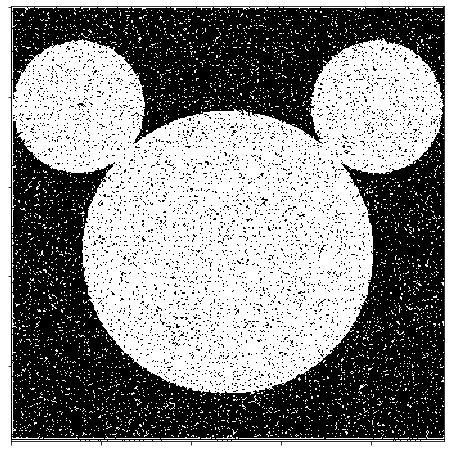

In [34]:
show_binary_image(input_image)

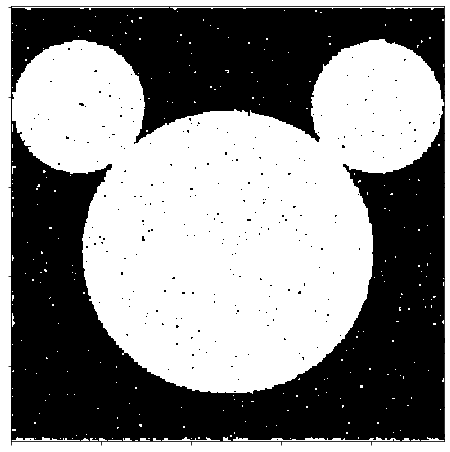

In [38]:
output_image = reduce_noise_using_gibbs_sampler(
    input_image,
    coupling_strength=4.0,
    iterations_count=1_000_000,
)
show_binary_image(output_image)

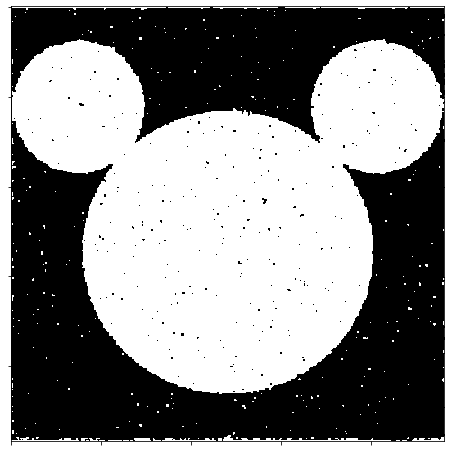

In [44]:
output_image = reduce_noise_using_gibbs_sampler(
    input_image,
    coupling_strength=20.0,
    iterations_count=1_000_000,
)
show_binary_image(output_image)